In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision.transforms.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import torchvision
from torchvision import models, transforms
from torchvision.datasets.folder import make_dataset
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

%matplotlib inline
plt.ion()   # interactive mode

In [ ]:
pip install torchsummary

In [2]:
from torchsummary import summary

### To test for pre-trained
1. Inception + Adam
2. VGG adam optimiser debug (if any)

## 1. Loading data


In [96]:
# Define the dataset class
class sg_food_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        self.classes = [all_classes[x] for x in class_id]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

        self.samples = make_dataset(self.root, self.class_to_idx, extensions=('jpg'))
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        with open(path, "rb") as f:
            sample = Image.open(f).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [97]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        # Define data preparation operations for training set here.
        # Tips: Use torchvision.transforms
        #       https://pytorch.org/vision/stable/transforms.html
        #       Normally this should at least contain resizing (Resize) and data format converting (ToTensor).
        transforms.RandomResizedCrop(224),
        transforms.ColorJitter(brightness=0.1, contrast=0.1 , saturation = 0.1), #random brightness, contrast etc
        transforms.GaussianBlur(kernel_size=(15, 15)),
        transforms.ColorJitter(brightness=0.2, contrast=0.3 , saturation = 0.2, hue=0.3), #random brightness, contrast etc
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
    'val': transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256, antialias=True),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ]),
}

data_dir = './sg_food' 
subfolder = {'train': 'train', 'val': 'val'}

# Define the dataset
selected_classes = [0, 2, 4, 7, 9]
n_classes = len(selected_classes)
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader 64=default, 128=adam
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

selected classes:
    id: [0, 2, 4, 7, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata']


In [77]:
device

device(type='cpu')

## 2. Visualizing the dataset
Fetch a batch of training data from the dataset and visualize them. 



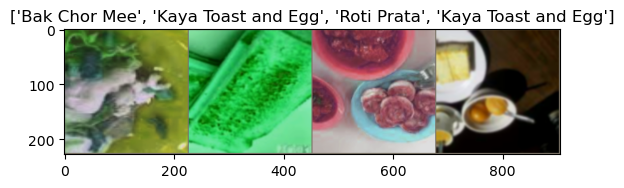

In [34]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

## 3. Model Initailization

### 3.1 Define Models

In [98]:
# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True)

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Load the pre-trained Inception v3 model
inception_v3 = models.inception_v3(pretrained=True)

# Load the pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)


### 3.2 Modify Models

In [99]:
# Set num of classes
num_classes = 5

# Modify VGG16
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify VGG19
vgg19.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Modify Resnet50
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Modify Inception_v3
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(inception_v3.AuxLogits.fc.in_features, num_classes)

In [90]:
# Summary

# VGG16
summary(vgg16.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [83]:
# VGG19
summary(vgg19.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [84]:
# ResNet18
summary(resnet18.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [85]:
#Resnet 50
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [91]:
# Inception_v3
summary(inception_v3.to(device), input_size=(3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

### 3.3 Dict for Models

In [107]:
models_dict = {
    #"VGG16": vgg16,
    #"VGG19": vgg19,
    #"ResNet18": resnet18,
    "ResNet50":resnet50,
    #"Inception_v3": inception_v3
}

## 4. Training

In [100]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0                

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                if is_inception and phase == 'train':
                    inputs = torch.stack([F.resize(input, size=(299, 299)) for input in inputs])

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [101]:
def visualize_training(val_acc_history):
    plt.figure()
    # 确保将 tensor 转移到 CPU
    val_acc_history_cpu = [h.cpu() for h in val_acc_history]
    plt.plot(val_acc_history_cpu)
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy")
    plt.title("Training History")
    plt.show()

Training ResNet50...
Epoch 1/25
----------
train Loss: 1.7064 Acc: 0.3280
val Loss: 2.5838 Acc: 0.2000

Epoch 2/25
----------
train Loss: 1.6213 Acc: 0.3540
val Loss: 12.4026 Acc: 0.3333

Epoch 3/25
----------
train Loss: 1.5108 Acc: 0.3380
val Loss: 3.2463 Acc: 0.3467

Epoch 4/25
----------
train Loss: 1.4739 Acc: 0.3360
val Loss: 1.4554 Acc: 0.3933

Epoch 5/25
----------
train Loss: 1.3216 Acc: 0.4500
val Loss: 2.0968 Acc: 0.3933

Epoch 6/25
----------
train Loss: 1.2742 Acc: 0.4780
val Loss: 1.3172 Acc: 0.4333

Epoch 7/25
----------
train Loss: 1.2867 Acc: 0.4800
val Loss: 1.3001 Acc: 0.4000

Epoch 8/25
----------
train Loss: 1.2601 Acc: 0.4600
val Loss: 1.9278 Acc: 0.4267

Epoch 9/25
----------
train Loss: 1.2138 Acc: 0.5020
val Loss: 1.3424 Acc: 0.5400

Epoch 10/25
----------
train Loss: 1.1596 Acc: 0.5320
val Loss: 1.1274 Acc: 0.5600

Epoch 11/25
----------
train Loss: 1.1171 Acc: 0.5400
val Loss: 1.7802 Acc: 0.4067

Epoch 12/25
----------
train Loss: 1.1079 Acc: 0.5140
val Loss:

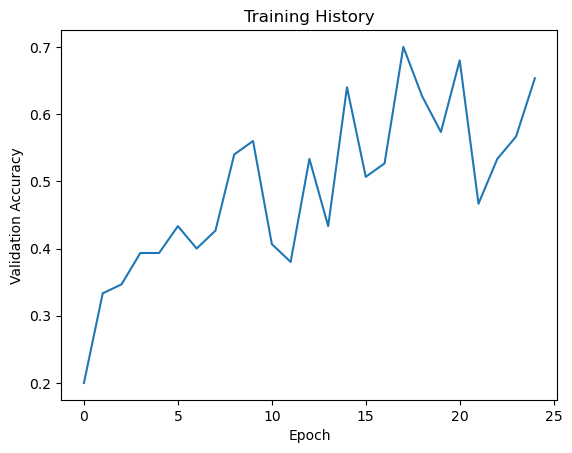

In [108]:
# Loop through each model for training
for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Define Criterion
    criterion = nn.CrossEntropyLoss()
    
    # Define Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Inception_v3
    #is_inception = (model_name == "Inception_v3")
    
    trained_model, val_acc_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=25)
    
    # Visualize Training Result
    visualize_training(val_acc_history)
    
    # Save Checkpoints
    torch.save(trained_model.state_dict(), f"./models/{model_name}_model_Adam.pth")

**Train Swin Transformer (tiny) with lr scheduler**

In [ ]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [ ]:
HUB_URL = "SharanSMenon/swin-transformer-hub:main"
MODEL_NAME = "swin_tiny_patch4_window7_224"
# check hubconf for more models.
model = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True) # load from torch hub

In [ ]:
for param in model.parameters(): #freeze model
    param.requires_grad = False
print(model.head)
n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 5)
)
model = model.to(device)
print(model.head)

In [ ]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.AdamW(model.head.parameters(), lr=0.001)
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0                

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history


In [ ]:
trained_model, val_acc_history = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=25)
    
# Visualize Training Result
visualize_training(val_acc_history)
    
# Save Checkpoints
torch.save(trained_model.state_dict(), f"./data/swin_tiny.pth")

### 4.2 Finetuning Model

# 5. Prediction and Evaluation

In [34]:
# Load the pre-trained Swin_tiny model
#HUB_URL = "SharanSMenon/swin-transformer-hub:main"

#MODEL_NAME = "swin_tiny_patch4_window7_224"
#swin_tiny = torch.hub.load(HUB_URL, MODEL_NAME, pretrained=True)

# Load the pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Load the pre-trained Inception v3 model
inception_v3 = models.inception_v3(pretrained=True)

#Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True)

#Load the pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)

c:\Users\Admin\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Admin\anaconda3\envs\pytorch_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=Res

In [35]:
# Set num of classes
num_classes = 5

# Modify VGG16
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify VGG19
vgg19.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Modify ResNet18
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Modify Resnet50
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Modify Inception_v3
inception_v3.fc = nn.Linear(inception_v3.fc.in_features, num_classes)
inception_v3.AuxLogits.fc = nn.Linear(inception_v3.AuxLogits.fc.in_features, num_classes)

# Modify Swin_tiny
'''
swin_tiny.head = nn.Sequential(
    nn.Linear(768, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes)
)
'''

'\nswin_tiny.head = nn.Sequential(\n    nn.Linear(768, 512),\n    nn.ReLU(),\n    nn.Dropout(0.3),\n    nn.Linear(512, num_classes)\n)\n'

In [114]:
models_dict = {
    "VGG16": vgg16,
    "ResNet18": resnet18,
    #"Inception_v3": inception_v3,
    #"SwinTransformer_tiny": swin_tiny
    #"VGG19": vgg19,
    #"ResNet50": resnet50,
}

In [115]:
# Data normalization for testing
test_data_transform = transforms.Compose([
        # Define data preparation operations for testing/validation set here.
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # ImageNet prior
    ])

data_dir = './sg_food' 

# Define the dataset
selected_classes = [0, 2, 4, 7, 9]
n_classes = len(selected_classes)
test_image_dataset = sg_food_dataset(root=os.path.join(data_dir, 'test'),
                                     class_id=selected_classes,
                                     transform=test_data_transform) 
class_names = test_image_dataset.classes
print('selected classes:\n    id: {}\n    name: {}'.format(selected_classes, class_names))

# Define the dataloader 64=default, 128=adam
batch_size = 128
test_dataloader = torch.utils.data.DataLoader(test_image_dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=0)

test_dataset_size = len(test_image_dataset)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

selected classes:
    id: [0, 2, 4, 7, 9]
    name: ['Bak Chor Mee', 'Chicken Rice', 'Kaya Toast and Egg', 'Oyster Omelette', 'Roti Prata']


device(type='cpu')

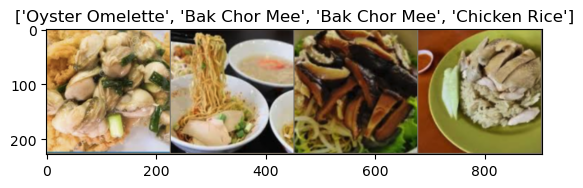

In [45]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(test_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=[class_names[x] for x in classes[:4]])

In [116]:
best_model_paths = {
    "VGG16": "./models/VGG16_model_Adam.pth",
    #"ResNet18": "./models/ResNet18_model_adam.pth",
    #"Inception_v3": "/kaggle/input/inception_v3/pytorch/v1/1/Inception_v3_model.pth",
    #"SwinTransformer_tiny": "/kaggle/input/swin_tiny/pytorch/v1/1/swin_tiny.pth"
    #"VGG19": "./models/VGG19_model_adam.pth",
    #"ResNet50": "./models/ResNet50_model_adam.pth",
}

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(model,test_dataloader,class_names):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):   
                label = labels[i]
                #for confusion matrix
                y_true.append(label.to('cpu'))
                y_pred.append(predicted[i].to('cpu'))
                
        
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["BCM","CR","KTE","OO","RP"])
    disp.plot()
    plt.title("confusion matrix")
    plt.show()
    
    

Testing VGG16...
                    precision    recall  f1-score   support

      Bak Chor Mee       0.00      0.00      0.00       200
      Chicken Rice       0.15      0.25      0.19       200
Kaya Toast and Egg       0.00      0.00      0.00       200
   Oyster Omelette       0.21      0.71      0.32       200
        Roti Prata       0.00      0.00      0.00       200

          accuracy                           0.19      1000
         macro avg       0.07      0.19      0.10      1000
      weighted avg       0.07      0.19      0.10      1000



c:\Users\Admin\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Admin\anaconda3\envs\pytorch_env\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


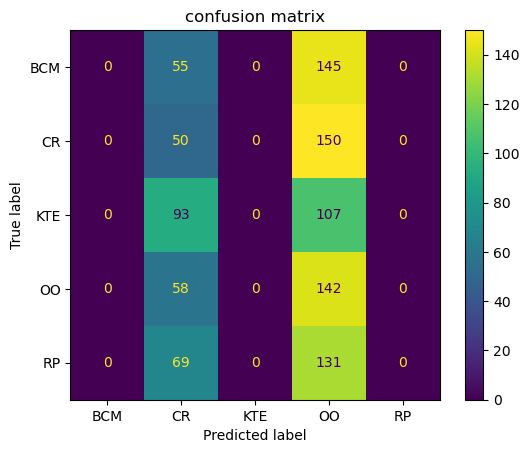

Testing ResNet18...


KeyError: 'ResNet18'

In [119]:
for model_name, model in models_dict.items():
    if model_name == "VGG19":
        continue
    print(f"Testing {model_name}...")
    
    model.to(device)
    model.load_state_dict(torch.load(best_model_paths[model_name]))
    model.eval()
    evaluate(model,test_dataloader,class_names)
    

### advanced 1

In [ ]:
# Load ResNet18
model = models.resnet18(pretrained=False)

# Modify Model, Remove FC Layer
num_ftrs = model.fc.in_features
model.fc = torch.nn.Identity()

# Load pretrained weight
model.load_state_dict(torch.load("/kaggle/input/resnet18-v1/pytorch/v1/1/ResNet18_model.pth"),strict = False)
model.eval()

In [ ]:
class sg_food_dataset(torch.utils.data.Dataset):
    def __init__(self, root, class_id, transform=None):
        self.class_id = class_id
        self.root = root
        all_classes = sorted(entry.name for entry in os.scandir(root) if entry.is_dir())
        if not all_classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
        
        # 创建新的类别列表，包括指定的类别和一个"Other"类别
        self.classes = [all_classes[x] for x in class_id] + ['Other']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes[:-1])}
        self.class_to_idx['Other'] = len(self.classes) - 1  # 'Other'类别的索引

        # 更新make_dataset函数调用，以支持"Other"类别
        self.samples = self.make_dataset(self.root, self.class_to_idx, extensions=('jpg'), class_id=class_id)
        self.transform = transform

    def make_dataset(self, directory, class_to_idx, extensions=None, class_id=None):
        instances = []
        directory = os.path.expanduser(directory)
        both_none = extensions is None
        if not both_none:
            def is_valid_file(x):
                return x.lower().endswith(extensions)
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(directory, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    if both_none or is_valid_file(path):
                        # 若当前类别不在selected_classes中，将其归为"Other"
                        if class_index not in class_id:
                            instances.append((path, class_to_idx['Other']))
                        else:
                            instances.append((path, class_index))
        return instances



In [ ]:

# 数据目录和子目录保持不变
data_dir = '/kaggle/input/sg-food/sg_food' 
subfolder = {'train': 'train', 'val': 'val'}

# 选定的类别索引不变，因为sg_food_dataset类内部会处理Other类别
selected_classes = [0, 2, 4, 7, 9]

# 定义数据集时保持原有逻辑
image_datasets = {x: sg_food_dataset(root=os.path.join(data_dir, subfolder[x]),
                                     class_id=selected_classes,
                                     transform=data_transforms[x]) 
                  for x in ['train', 'val']}

# 更新类别名称的获取逻辑，现在包括了"Other"类别
class_names = image_datasets['train'].classes  # 现在这里已经包含了"Other"
print('Selected classes:\n    ID: {}\n    Name: {}'.format(selected_classes + ['Other'], class_names))

# 定义数据加载器和设备选择的逻辑保持不变
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Vision transformer exploration

In [3]:
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_ds = torchvision.datasets.ImageFolder('./sg_food/train/', transform=transform)
valid_ds = torchvision.datasets.ImageFolder('./sg_food/val/', transform=transform)
test_ds = torchvision.datasets.ImageFolder('./sg_food/test/', transform=transform)

In [4]:
def filter_dataset(dataset, selected_classes):
    # Filter the dataset samples based on the selected class IDs
    filtered_samples = [(img, label) for img, label in dataset.samples if label in selected_classes]
    # Update the dataset's samples and targets
    dataset.samples = filtered_samples
    dataset.targets = [label for _, label in filtered_samples]
    # Update the class_to_idx attribute based on the filtered classes
    dataset.class_to_idx = {class_name: idx for class_name, idx in dataset.class_to_idx.items() if idx in selected_classes}
    return dataset

selected_classes = [0, 2, 4, 7, 9]

train_ds = filter_dataset(train_ds, selected_classes)
valid_ds = filter_dataset(valid_ds, selected_classes)
test_ds = filter_dataset(test_ds, selected_classes)

In [5]:
print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Detected Classes are: ", train_ds.class_to_idx)

Number of train samples:  500
Number of test samples:  1000
Detected Classes are:  {'Bak Chor Mee': 0, 'Chicken Rice': 2, 'Kaya Toast and Egg': 4, 'Oyster Omelette': 7, 'Roti Prata': 9}


In [6]:
from transformers import ViTModel
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn
import torch.nn.functional as F

# Define the model
class ViTForImageClassification(nn.Module):
    def __init__(self, num_labels, other_argument=None):
        super(ViTForImageClassification, self).__init__()
        # Your model initialization code here
        # Example:
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values, labels=None):
        # Your forward pass code here
        # Example:
        outputs = self.vit(pixel_values=pixel_values)
        output = self.dropout(outputs.last_hidden_state[:, 0])
        logits = self.classifier(output)

        if labels is not None:
            # Calculate loss
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            return loss
        else:
            return logits


In [7]:
EPOCHS = 12
BATCH_SIZE = 64
LEARNING_RATE = 2e-5

In [8]:
from transformers import ViTFeatureExtractor
import torch.nn as nn
import torch
# Define Model
model = ViTForImageClassification(len(train_ds.classes))    
# Feature Extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Cross Entropy Loss
loss_func = nn.CrossEntropyLoss()
# Use GPU if available  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
if torch.cuda.is_available():
    model.cuda() 

c:\Users\Admin\anaconda3\envs\pytorch_env\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
import torch.utils.data as data
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image


train_loader = data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

# Training loop
for epoch in range(EPOCHS):
    # Use tqdm to track progress
    with tqdm(train_loader, unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            if (i+1) % 100 == 0:
                t.set_description(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')
    
    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            preds = output.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    accuracy = correct / total
    print(f'Epoch: {epoch+1} | Test Accuracy: {accuracy:.4f}')



100%|██████████| 8/8 [04:39<00:00, 34.99s/batch]


Epoch: 1 | Test Accuracy: 0.6480


100%|██████████| 8/8 [04:52<00:00, 36.51s/batch]


Epoch: 2 | Test Accuracy: 0.7240


100%|██████████| 8/8 [04:39<00:00, 34.97s/batch]


Epoch: 3 | Test Accuracy: 0.7960


100%|██████████| 8/8 [04:34<00:00, 34.27s/batch]


Epoch: 4 | Test Accuracy: 0.8520


100%|██████████| 8/8 [04:34<00:00, 34.25s/batch]


Epoch: 5 | Test Accuracy: 0.8960


100%|██████████| 8/8 [04:35<00:00, 34.41s/batch]


Epoch: 6 | Test Accuracy: 0.9040


100%|██████████| 8/8 [04:35<00:00, 34.38s/batch]


Epoch: 7 | Test Accuracy: 0.9160


100%|██████████| 8/8 [04:36<00:00, 34.50s/batch]


Epoch: 8 | Test Accuracy: 0.9260


100%|██████████| 8/8 [04:41<00:00, 35.19s/batch]


Epoch: 9 | Test Accuracy: 0.9310


100%|██████████| 8/8 [04:42<00:00, 35.27s/batch]


Epoch: 10 | Test Accuracy: 0.9270


100%|██████████| 8/8 [04:38<00:00, 34.80s/batch]


Epoch: 11 | Test Accuracy: 0.9290


100%|██████████| 8/8 [04:36<00:00, 34.62s/batch]


Epoch: 12 | Test Accuracy: 0.9330


In [13]:
torch.save(model, './models/model_ViT.pt')

                    precision    recall  f1-score   support

      Bak Chor Mee       0.95      0.95      0.95       200
      Chicken Rice       0.94      0.90      0.92       200
Kaya Toast and Egg       0.92      0.97      0.94       200
   Oyster Omelette       0.90      0.94      0.92       200
        Roti Prata       0.96      0.90      0.93       200

          accuracy                           0.93      1000
         macro avg       0.93      0.93      0.93      1000
      weighted avg       0.93      0.93      0.93      1000



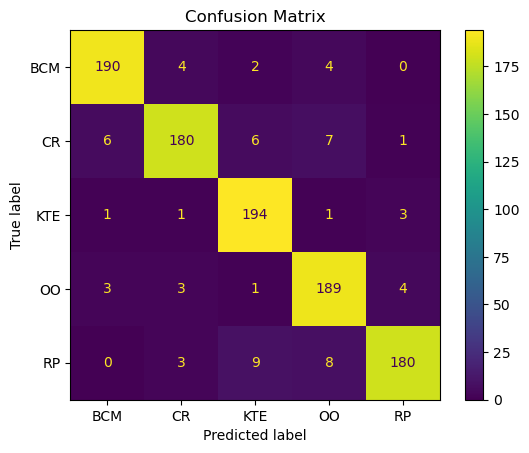

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def evaluate(model, test_dataloader, class_names):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):   
                label = labels[i]
                # For confusion matrix
                y_true.append(label.to('cpu'))
                y_pred.append(predicted[i].to('cpu'))

    # Classification report
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion matrix
    matrix = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["BCM", "CR", "KTE", "OO", "RP"])
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

# Usage
evaluate(model, test_loader, ["Bak Chor Mee", "Chicken Rice", "Kaya Toast and Egg", "Oyster Omelette", "Roti Prata"])

In [21]:
import random

def display_random_images(model, test_loader, class_names):
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                if random.random() < 5 / len(test_loader.dataset):
                    label = labels[i].item()
                    plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
                    plt.title(f"True: {class_names[label]}, Predicted: {class_names[predicted[i].item()]}")
                    plt.axis('off')
                    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


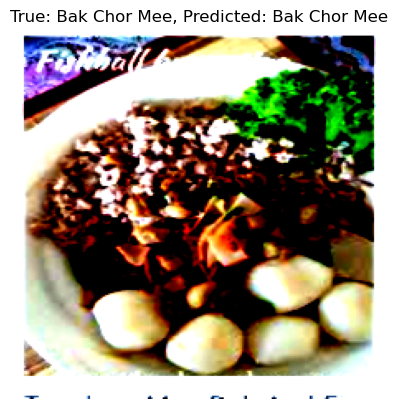

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


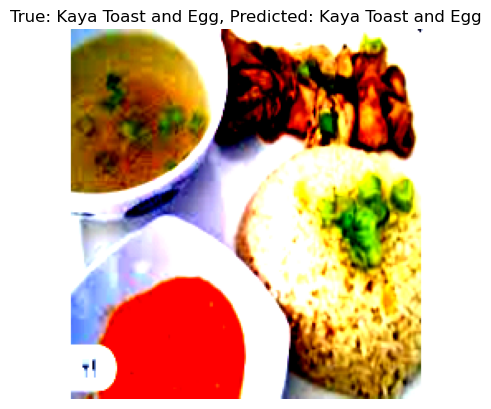

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: list index out of range

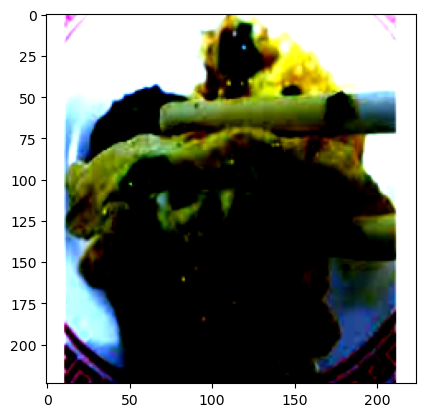

In [22]:
display_random_images(model, test_loader, ["Bak Chor Mee", "Chicken Rice", "Kaya Toast and Egg", "Oyster Omelette", "Roti Prata"])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

EVAL_BATCH = 1
eval_loader  = data.DataLoader(valid_ds, batch_size=EVAL_BATCH, shuffle=True, num_workers=4) 
# Disable grad
with torch.no_grad():
    
  inputs, target = next(iter(eval_loader))
  # Reshape and get feature matrices as needed
  print(inputs.shape)
  inputs = inputs[0].permute(1, 2, 0)
  # Save original Input
  originalInput = inputs
  for index, array in enumerate(inputs):
    inputs[index] = np.squeeze(array)
  inputs = torch.tensor(np.stack(feature_extractor(inputs)['pixel_values'], axis=0))

  # Send to appropriate computing device
  inputs = inputs.to(device)
  target = target.to(device)
 
  # Generate prediction
  prediction, loss = model(inputs, target)
    
  # Predicted class value using argmax
  predicted_class = np.argmax(prediction.cpu())
  value_predicted = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(predicted_class)]
  value_target = list(valid_ds.class_to_idx.keys())[list(valid_ds.class_to_idx.values()).index(target)]
        
  # Show result
  plt.imshow(originalInput)
  plt.xlim(224,0)
  plt.ylim(224,0)
  plt.title(f'Prediction: {value_predicted} - Actual target: {value_target}')
  plt.show()